# Titanic Dataset Analysis via NN
Dataset: https://www.kaggle.com/c/titanic/overview <br>
Useful link: https://docs.fast.ai/tutorial.tabular
and https://docs.fast.ai/tabular.core.html


In [ ]:
!pip install -q kaggle

import os 
os.environ['KAGGLE_USERNAME'] = "filippoairaldi"
os.environ['KAGGLE_KEY'] = "51aebb4dfedacca5d50c2ab359457daa" 

!mkdir titanic_data
!kaggle competitions download -c titanic -p titanic_data

!pip install fastai --upgrade
!pip install nbdev

In [2]:
import re
import numpy as np
import pandas as pd
from fastai.tabular.all import *

In [3]:
def get_train_data(): return pd.read_csv('titanic_data/train.csv')
def get_test_data(): return pd.read_csv('titanic_data/test.csv')

## Pre-processing

### PassengerId

In [4]:
def process_passenger_id(df): # insignificat
    return df.drop('PassengerId', axis = 1)

### Title and Name

In [5]:
titles_dict = {
    'Capt': 'Offical',
    'Col': 'Offical',
    'Rev': 'Offical',
    'Dr': 'Offical',
    'Major': 'Offical',
    'Don': 'Royalty',
    'Jonkheer': 'Royalty',
    'Sir': 'Royalty',
    'Dona': 'Royalty',
    'the Countess': 'Royalty',
    'Lady': 'Royalty',
    'Master': 'Commoner',
    'Miss': 'Commoner',
    'Mlle': 'Commoner',
    'Mme': 'Commoner',
    'Mr': 'Commoner',
    'Mrs': 'Commoner',
    'Ms': 'Commoner'
}

def process_name(df):
    def process_name_to_ticket(df):
        def extract_title_from_name(n):
            try:
                return n.split(',')[1].split('.')[0].strip()
            except:
                return np.nan
        df['Title'] = df.Name.transform(extract_title_from_name).map(titles_dict)
        return df

    def process_children(df):
        df_train = get_train_data() # must use only train dataset
        train_max_male_child_age = df_train[df_train.Name.str.contains('Master.')].Age.max()
        df['IsChild'] = df.Age <= train_max_male_child_age
        return df

    def process_family(df):
        def extract_family_name(n):
            try:
                return n.split(',')[0]
            except:
                np.nan

        df_train = get_train_data() # must use only train dataset
        train_family_size_dict = df_train.Name.transform(extract_family_name).value_counts().to_dict()
        families = df.Name.transform(extract_family_name)
        df['FamilySize'] = df.Name.transform(extract_family_name).map(train_family_size_dict)
        return df

    df = process_name_to_ticket(df)
    df = process_children(df)
    df = process_family(df)
    return df.drop('Name', axis = 1)

### Ticket

In [6]:
def process_ticket(df): # random forest suggested tickets are not influential
    return df.drop('Ticket', axis = 1)

### Cabin

In [7]:
def process_cabin(df):
    def get_cabin_height(cabin):
        try:
            cabin = cabin.replace(' ', '')
            x = re.search('^([A-Z]+)([0-9]+)', cabin)
            if x is None:
                return np.nan
            return x[1]
        except:
            return np.nan
    def get_cabin_length(cabin):    
        try:
            cabin = cabin.replace(' ', '')
            x = re.search('^([A-Z]+)([0-9]+)', cabin)
            if x is None:
                return np.nan
            return x[2]
        except:
            return np.nan

    df['CabinHeight'] = df.Cabin.transform(get_cabin_height)
    df['CabinLength'] = df.Cabin.transform(get_cabin_length) # seems more important than height
    return df.drop('Cabin', axis = 1)

### Transform to categories or continuous variables

In [8]:
def get_cat_cols():
    return ['Pclass', 'Sex', 'Embarked', 'Title', 'CabinHeight', 'IsChild']

def get_cont_cols():
    return ['Age', 'CabinLength', 'Fare', 'Parch', 'SibSp', 'FamilySize']

def get_cols_types():
    return { 
        'Age': 'float32',
        'CabinLength': 'float32', # contains NaN, must be float
        'Fare': 'float32',
        'Parch': 'uint8',
        'SibSp': 'uint8',
        'FamilySize': 'float32', # contains NaN, must be float
        'Pclass': 'category',
        'Sex': 'category',
        'Embarked': 'category',
        'Title': 'category',
        'CabinHeight': 'category',
        'IsChild': 'category'
        }

def process_df_types(df):
    if 'Survived' in df.columns:
        df.Survived = df.Survived.astype('bool')

    df = df.astype(get_cols_types())

    df.Pclass.cat.set_categories([3, 2, 1], ordered = True, inplace = True)
    df.CabinHeight.cat.set_categories(
        ['G', 'FG', 'F', 'FE', 'E', 'D', 'C', 'B', 'A'], # A highest
        ordered = True, inplace = True)
    return df

# df_shrink_dtypes(df, int2uint = True) helpful function

### Fill missing values
Fill missing continuous values from the median of the corresponding (sex, title, pclass) group. If no entry is found, the overall median for the column is returned.<br>
Categorical columns are not filled since NaN is a category itself.

In [9]:
def fill_missing_values(df): 
    df_train = get_train_data() # always use train medians to fill any dataset 
    df_train = process_passenger_id(df_train)
    df_train = process_name(df_train)
    df_train = process_ticket(df_train)
    df_train = process_cabin(df_train)
    df_train = process_df_types(df_train)

    df.Embarked = df.Embarked.fillna('S') # most occurrent

    cont_cols = get_cont_cols()
    overall_train_median_dict = { c: df_train[c].median() for c in cont_cols }

    grouping_cols = ['Sex', 'Pclass', 'Title']
    df_train = df_train.groupby(grouping_cols).median().reset_index()
    df_train = df_train[grouping_cols + cont_cols]

    def first_or_default(arr, default):
        if arr.shape[0] == 0 or np.isnan(arr[0]):
            return default
        return arr[0]

    def fill_row_values(row):
        cond = ((df_train.Sex == row.Sex) &
                (df_train.Pclass == row.Pclass) &
                (df_train.Title == row.Title))
        matches = df_train[cond]
        for c in cont_cols:
            if not np.isnan(row[c]):
                continue
            val = matches[c].values
            row[c] = first_or_default(val, overall_train_median_dict[c])
        return row

    df[cont_cols] = df.apply(fill_row_values, axis = 1)[cont_cols]
    return df

### Dividing into train and validation set

In [10]:
def get_processed_train_data():
    df = get_train_data()
    df = process_passenger_id(df)
    df = process_name(df)
    df = process_ticket(df)
    df = process_cabin(df)
    df = process_df_types(df)
    df = fill_missing_values(df)
    return df

def convert_train_df_to_tabular(df):
    # FillMissing is not gonna really do anything because I manually filled continuous columns
    return TabularPandas(
        df,
        procs = [Categorify, FillMissing, Normalize],
        cat_names = get_cat_cols(),
        cont_names = get_cont_cols(),
        y_names = 'Survived',
        y_block = CategoryBlock(),
        splits = RandomSplitter(valid_pct = 0.33)(range_of(df)))

def get_train_to():
    return convert_train_df_to_tabular(get_processed_train_data())

## Modeling

In [14]:
# thanks to: https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/4
def random_seed(seed_value):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value)

In [54]:
random_seed(42)

to = get_train_to()
dls = to.dataloaders(bs = 256)

learn = tabular_learner(dls, metrics = accuracy, layers = [512, 128])

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0005754399462603033)

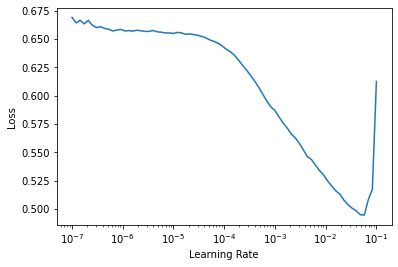

In [55]:
learn.lr_find()

In [56]:
learn.fit_one_cycle(75, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.656848,0.685950,0.598639,00:00
1,0.655382,0.685053,0.598639,00:00
2,0.652191,0.683441,0.598639,00:00
3,0.648872,0.681567,0.598639,00:00
4,0.644448,0.679426,0.598639,00:00
5,0.639427,0.676745,0.598639,00:00
6,0.632391,0.673386,0.602041,00:00
7,0.625182,0.669381,0.602041,00:00
8,0.615519,0.664863,0.608844,00:00
9,0.605434,0.659769,0.612245,00:00


## Submission

In [ ]:
def get_processed_test_data():
    df = get_test_data()
    df = process_passenger_id(df)
    df = process_name(df)
    df = process_ticket(df)
    df = process_cabin(df)
    df = process_df_types(df)
    df = fill_missing_values(df)
    return df

dl_test = learn.dls.test_dl(get_processed_test_data())

output = learn.get_preds(dl = dl_test)

In [ ]:
survived = output[0][:, 1] >= 0.5 

df_output = pd.DataFrame({
    'PassengerId': get_test_data().PassengerId,
    'Survived': survived
})
df_output.Survived = df_output.Survived.map(lambda f: 1 if f else 0)
df_output.to_csv('titanic_data/results.csv', index = False)